In [121]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

import joblib
import json

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 500
pd.options.display.max_rows = 500

In [122]:
import pandas as pd

# Set maximum number of rows to display
pd.set_option('display.max_rows', 10000)  # Show up to 100 rows
pd.set_option('display.max_columns', 2000)  # Show up to 20 columns
pd.set_option('display.width', 1000)  # Set display width
pd.set_option('display.max_colwidth', 50)  # Max characters per column


## Config

In [123]:
class Config:
    target_col = 'pm2_5'
    n_splits = 4
    random_state = 42
    id_col = 'id'
    missing_threshold = 0.7
    top_features = 70
    clip_threshold = 0.97
    corr_threshold = 0.9

    # Default hyperparameters
    cat_params = {
        'iterations': 1000,
        'learning_rate': 0.03,
        'depth': 6,
        'eval_metric': 'RMSE',
        'random_seed': random_state,
        'early_stopping_rounds': 250,
        'verbose': 100
    }
    lgb_params = {
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': -1,
        'random_state': random_state,
        'verbosity': -1
    }
    xgb_params = {
        'n_estimators': 100,
        'learning_rate': 0.3,
        'max_depth': 6,
        'random_state': random_state,
        'objective': 'reg:squarederror'
    }
    lasso_params = {'alpha': 0.001, 'random_state': random_state}
    svr_params = {'C': 1.0, 'epsilon': 0.1}

## Load data

In [124]:
# Load data
train = pd.read_csv('dataset/Train.csv')
test = pd.read_csv('dataset/Test.csv')

In [125]:
def align_train_test_columns(train_df, test_df, target_col=None):
    """
    Ensure train and test datasets have the same columns.
    
    Parameters:
    -----------
    train_df : pandas.DataFrame
        Training dataset
    test_df : pandas.DataFrame
        Test dataset
    target_col : str, optional
        Target column name to exclude from alignment (if present in train but not test)
    
    Returns:
    --------
    tuple : (train_df_aligned, test_df_aligned)
        Aligned train and test dataframes with the same columns
    """
    print(f"Train columns before alignment: {len(train_df.columns)}")
    print(f"Test columns before alignment: {len(test_df.columns)}")
    
    # Get common columns (excluding target if specified)
    if target_col not in train_df.columns:
        raise ValueError(f"Target column {target_col} not found in train dataset")

    common_cols = [col for col in train_df.columns if col in test_df.columns]
    print(f"Number of Common columns: {len(common_cols)}")
    
    # Find columns that are in train but not in test
    train_only_cols = [col for col in train_df.columns if col not in test_df.columns]
    if train_only_cols:
        print(f"Columns in train but not in test: {train_only_cols}")
    
    # Find columns that are in test but not in train
    test_only_cols = [col for col in test_df.columns if col not in train_df.columns]
    if test_only_cols:
        print(f"Columns in test but not in train: {test_only_cols}")
    
    # Align both datasets to have the same columns
    train_aligned = train_df[common_cols + [target_col]].copy()
    test_aligned = test_df[common_cols].copy()


    print(f"Train columns after alignment: {len(train_aligned.columns)}")
    print(f"Test columns after alignment: {len(test_aligned.columns)}")
    
    return train_aligned, test_aligned

# Apply the function to align train and test columns
train, test = align_train_test_columns(train, test, target_col=Config.target_col)


Train columns before alignment: 80
Test columns before alignment: 79
Number of Common columns: 79
Columns in train but not in test: ['pm2_5']
Train columns after alignment: 80
Test columns after alignment: 79


In [126]:
# CORRECTED VERSION: Remove columns with too many missing values
# print the number of columns before removing
print(f"Number of columns before removing: {len(train.columns)}")

before_removing_columns = train.columns
# Calculate null percentages BEFORE removing columns
null_percentages = train.isnull().mean()
train = train.loc[:, null_percentages < Config.missing_threshold]
after_removing_columns = train.columns
removed_columns = set(before_removing_columns) - set(after_removing_columns)

# null percentage of removed columns (using the original null percentages)
if removed_columns:
    removed_null_percentages = null_percentages[list(removed_columns)]
    print(f"Null percentage of removed columns:")
    print(removed_null_percentages)
    print(f"Number of removed columns: {len(removed_columns)}")
    print(f"Columns removed: {list(removed_columns)}")
else:
    print("No columns were removed")

# Remove the same columns from test set (based on removed_columns from train)
if removed_columns:
    # Get columns to keep in test (all columns except the ones removed from train)
    test_columns_to_keep = [col for col in test.columns if col not in removed_columns]
    test = test[test_columns_to_keep]
    print(f"Test columns after removing same columns as train: {len(test.columns)}")
else:
    print("No columns removed from test (no columns were removed from train)")

print(f"Final train columns: {len(train.columns)}")
print(f"Final test columns: {len(test.columns)}")


Number of columns before removing: 80
Null percentage of removed columns:
uvaerosollayerheight_aerosol_optical_depth    0.947095
uvaerosollayerheight_aerosol_pressure         0.947095
uvaerosollayerheight_solar_azimuth_angle      0.947095
uvaerosollayerheight_sensor_zenith_angle      0.947095
uvaerosollayerheight_solar_zenith_angle       0.947095
uvaerosollayerheight_sensor_azimuth_angle     0.947095
uvaerosollayerheight_aerosol_height           0.947095
dtype: float64
Number of removed columns: 7
Columns removed: ['uvaerosollayerheight_aerosol_optical_depth', 'uvaerosollayerheight_aerosol_pressure', 'uvaerosollayerheight_solar_azimuth_angle', 'uvaerosollayerheight_sensor_zenith_angle', 'uvaerosollayerheight_solar_zenith_angle', 'uvaerosollayerheight_sensor_azimuth_angle', 'uvaerosollayerheight_aerosol_height']
Test columns after removing same columns as train: 72
Final train columns: 73
Final test columns: 72


In [127]:
# Create GroupKFold
def create_folds(data):
    data['folds'] = -1
    gkf = GroupKFold(n_splits=Config.n_splits)
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X=data, groups=data['city']), start=1):
        data.loc[val_idx, 'folds'] = fold
    return data

train = create_folds(train)

### Explore data

In [128]:
train.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,folds
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000,3
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200,3
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-03,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.097816,828878.6875,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,0.756392,45185.49959,6791.682888,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,39.450741,3
3,id_9aandqzy4n,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-08,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [129]:
# Calculate PM2.5 standard deviation per location
location_variance = train.groupby('city')[Config.target_col].std().reset_index()
location_variance.columns = ['city', 'pm2_5_std']
location_variance = location_variance.sort_values(by='pm2_5_std', ascending=False).reset_index(drop=True)
print(location_variance)

print()
# Calculate PM2.5 mean per location
location_mean = train.groupby('city')[Config.target_col].mean().reset_index()
location_mean.columns = ['city', 'pm2_5_mean']
location_mean = location_mean.sort_values(by='pm2_5_mean', ascending=False).reset_index(drop=True)
print(location_mean)

        city  pm2_5_std
0      Lagos  52.843883
1    Nairobi  24.982218
2  Bujumbura  22.353384
3    Kampala  14.346829

        city  pm2_5_mean
0      Lagos   46.213294
1  Bujumbura   30.698758
2    Kampala   22.765384
3    Nairobi   18.879330


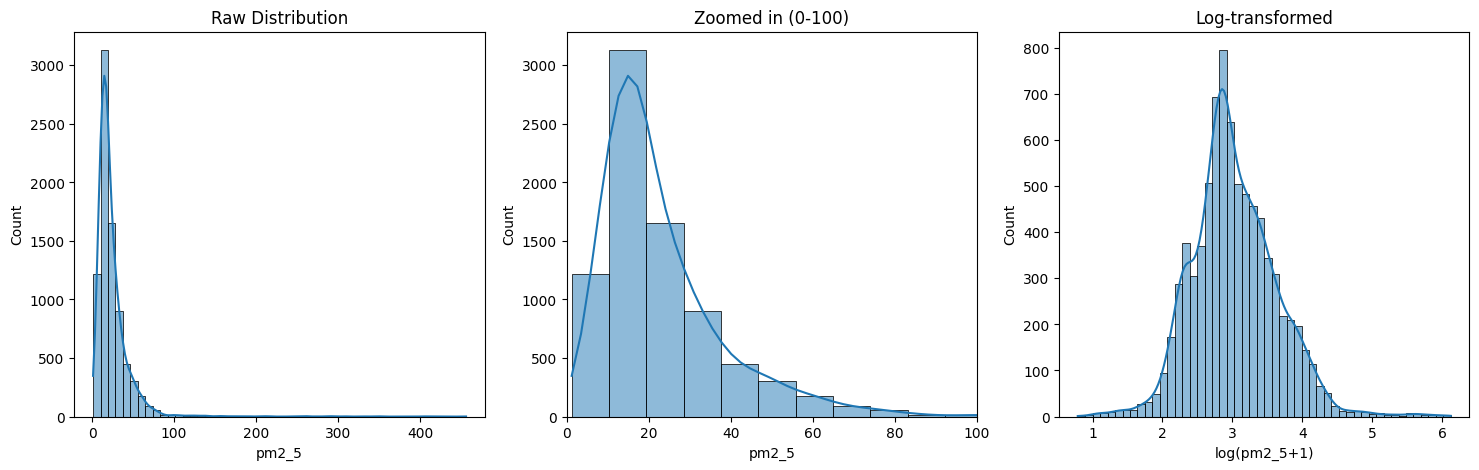

In [130]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(train["pm2_5"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Raw Distribution")

sns.histplot(train["pm2_5"], bins=50, kde=True, ax=axes[1])
axes[1].set_xlim(0, 100)
axes[1].set_title("Zoomed in (0-100)")

sns.histplot(np.log1p(train["pm2_5"]), bins=50, kde=True, ax=axes[2])
axes[2].set_title("Log-transformed")
axes[2].set_xlabel("log(pm2_5+1)")

plt.show()


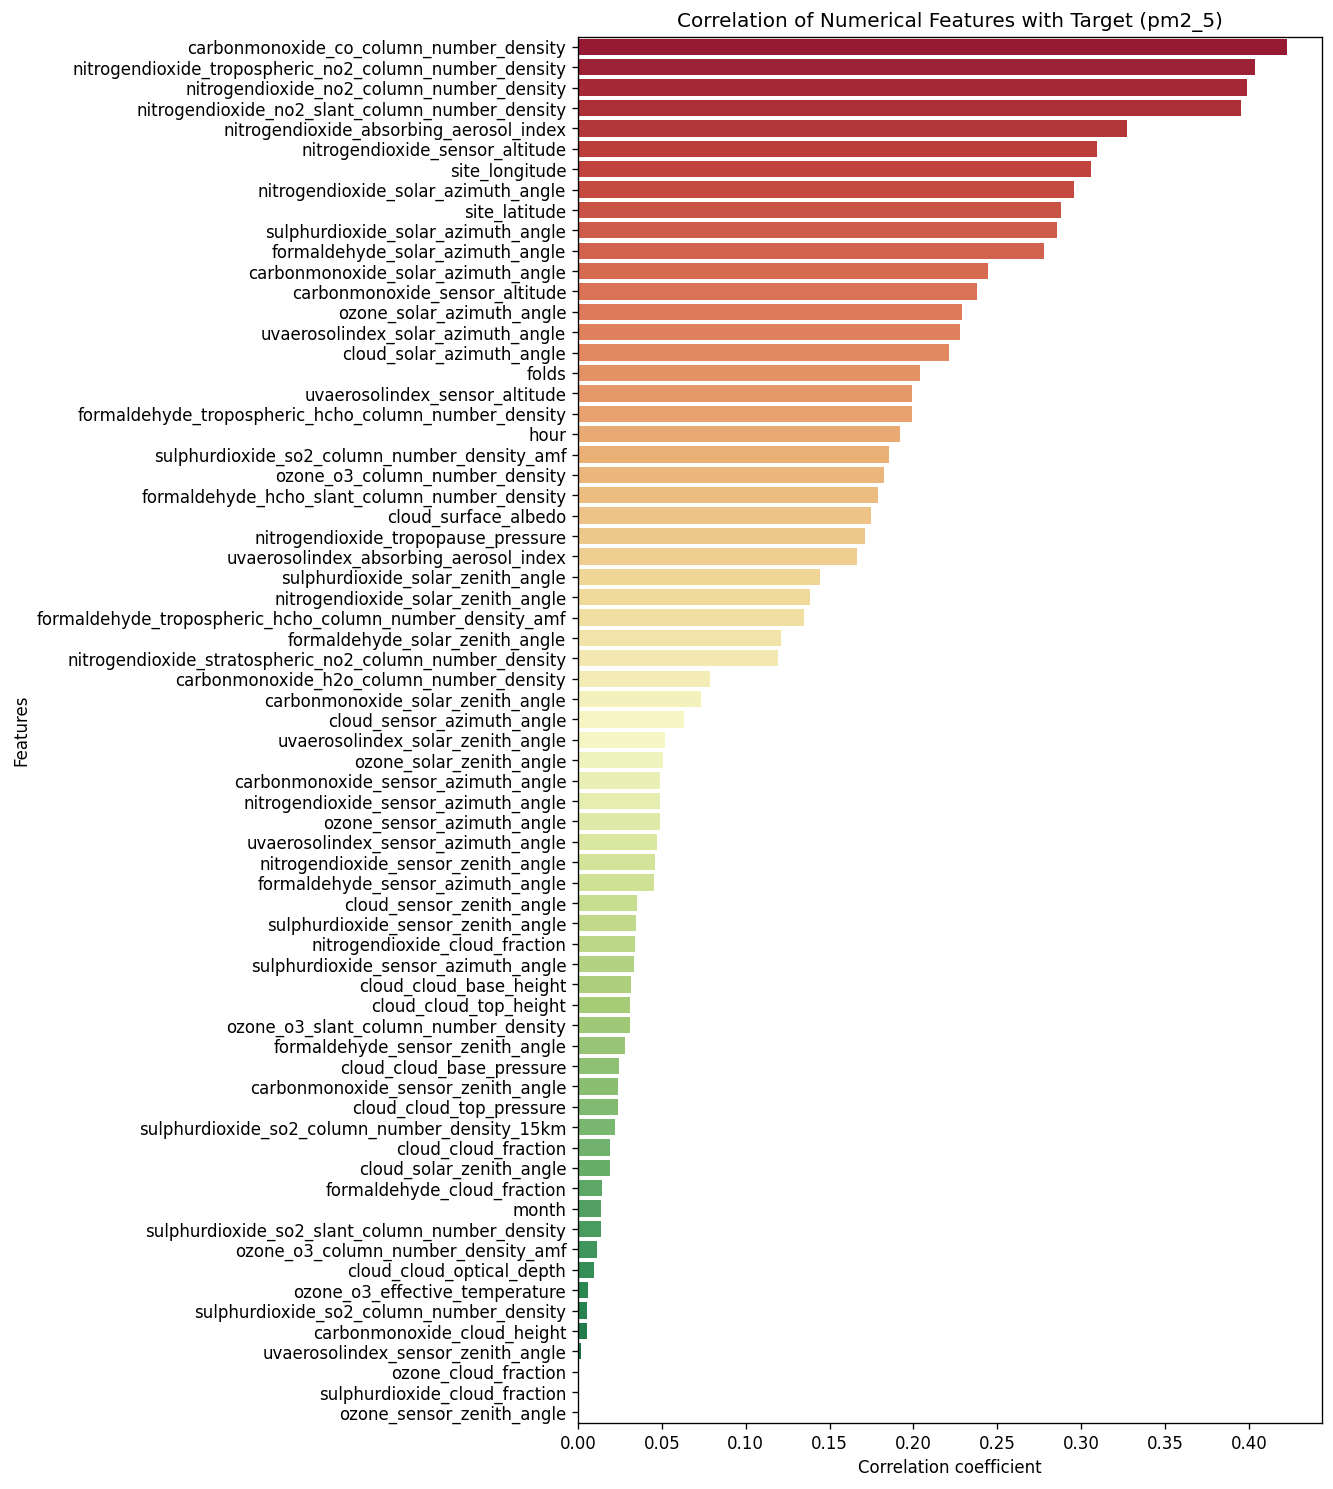

In [131]:
train_num_df = train.select_dtypes(include=['number'])

# Correlation with target
corr_with_target = train_num_df.corr()['pm2_5'].drop('pm2_5').sort_values(key=abs, ascending=False)

plt.figure(figsize=(8, 15), dpi=120)
sns.barplot(x=abs(corr_with_target.values), y=corr_with_target.index, palette="RdYlGn")
plt.title("Correlation of Numerical Features with Target (pm2_5)")
plt.xlabel("Correlation coefficient")
plt.ylabel("Features")
plt.show()



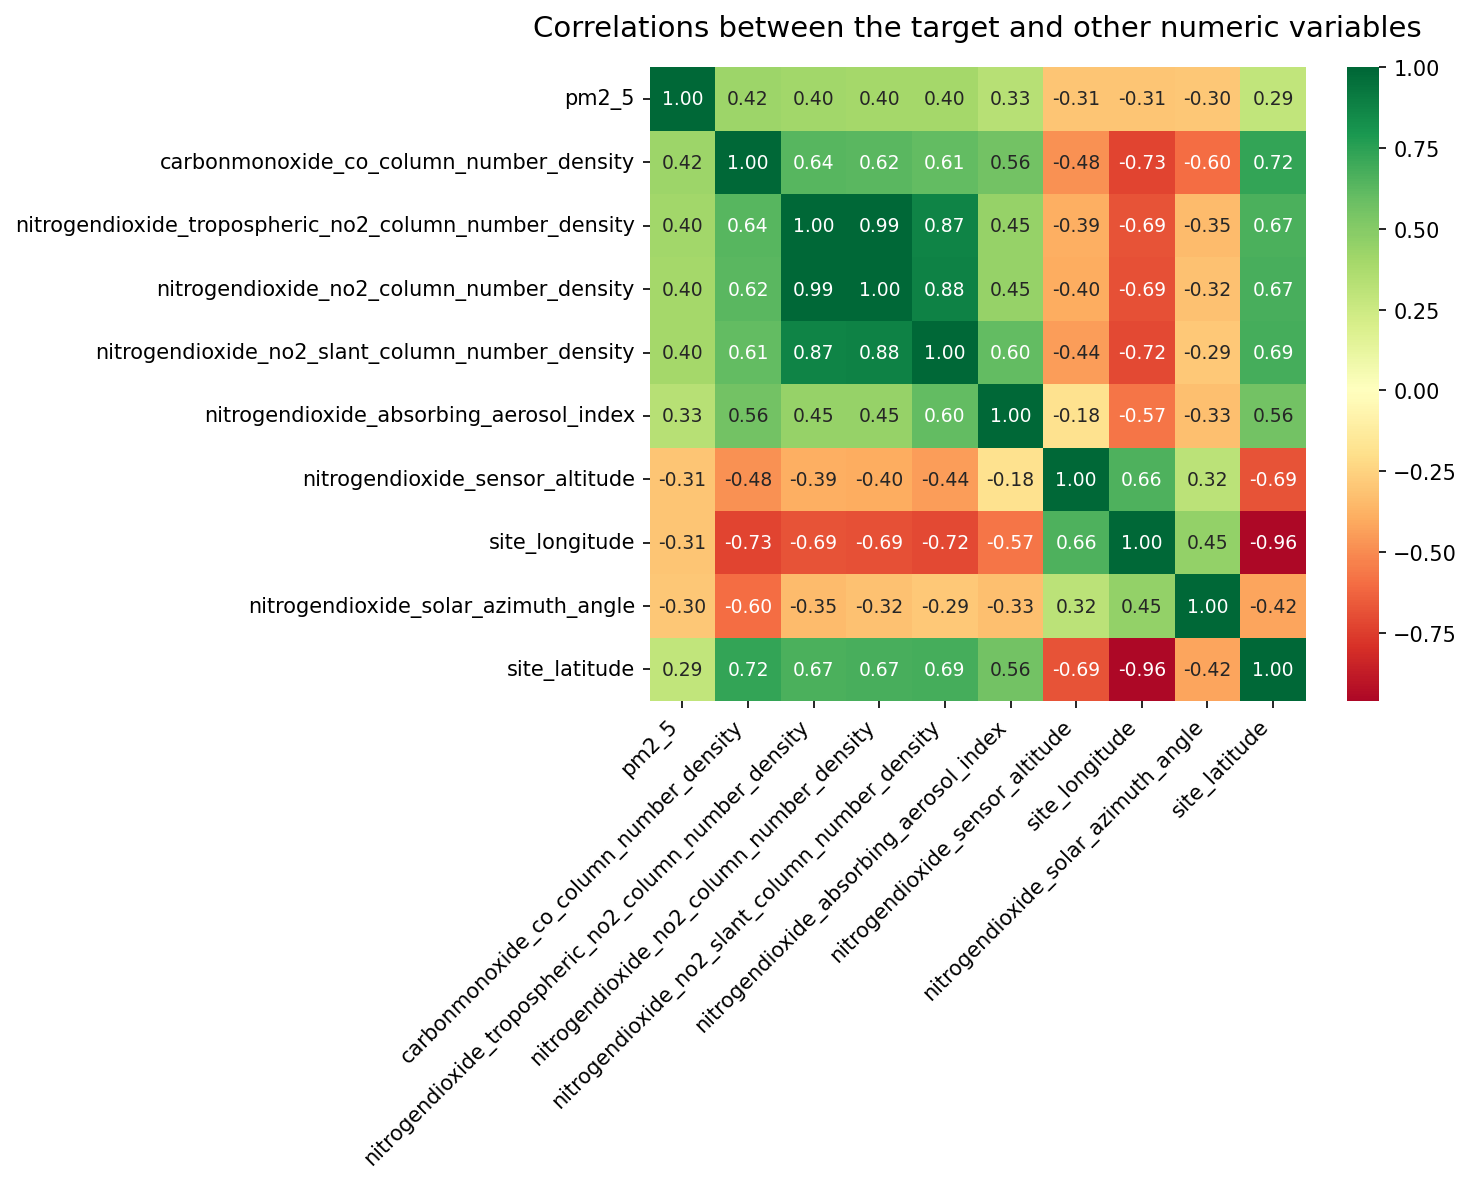

In [132]:
# Plot correlations between numerical features and target
train_num_df = train.select_dtypes(include=['number'])
top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending=False).head(10)
corr = train_num_df[list(top10_corrs.index)].corr()

plt.figure(figsize=(10, 8), dpi=150)
sns.heatmap(
    corr, cmap='RdYlGn', annot=True, center=0, fmt=".2f", 
    annot_kws={"size": 9}
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlations between the target and other numeric variables', pad=15, fontdict={'size': 14})
plt.tight_layout()
plt.show()

## Feature engineering

In [133]:
# Feature engineering

def feature_engineering(train, test):
    le = LabelEncoder()
    data = pd.concat([train, test])
    data['location'] = data['site_latitude'].astype('str') + '_' + data['site_longitude'].astype('str')
    data = data.sort_values(by = ['city','location', 'date', 'hour'])
    categorical_cols = data.select_dtypes(include='object').columns.tolist()
    categorical_cols = [col for col in categorical_cols if col not in ['date', 'id', 'city', 'country']]
    print(f'Categorical columns: {categorical_cols}')

    # Date features
    data['date'] = pd.to_datetime(data['date'])
    data['month'] = data['date'].dt.month
    data['week'] = data['date'].dt.isocalendar().week
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['is_weekend'] = data['dayofweek'].isin([5,6]).astype(int)

    numerical_cols = data.select_dtypes(exclude='object').columns.tolist()
    numerical_cols.remove(Config.target_col)
    numerical_cols.remove('folds')
    numerical_cols.remove('hour')
    numerical_cols.remove('site_latitude')
    numerical_cols.remove('site_longitude') 
    print(f'Numerical columns: {numerical_cols}')

    # Fill in missing values by forward and backward fill within each city and location
    nan_cols = [col for col in numerical_cols if data[col].isnull().sum() > 0 and col not in [Config.target_col, "folds"]]
    for col in nan_cols:
        data[col] = (
            data.groupby(["city", "location"])[col]
                .transform(lambda x: x.ffill().bfill())
                .fillna(data[col].median())  # global fallback
            )

    # Encode categorical features
    for col in categorical_cols + ['date']:
        data[col] = le.fit_transform(data[col])

    # Split back into train and test
    train  = data[data['id'].isin(train['id'].unique())]
    test = data[data['id'].isin(test['id'].unique())]

    features = [col for col in data.columns if col not in 
                [Config.target_col, Config.id_col, 'folds', 'country', 'city', 'site_id', 'site_latitude', 'site_longitude']]
  
    return train, test, features

train, test, features = feature_engineering(train, test)
print(len(features))

Categorical columns: ['site_id', 'location']
Numerical columns: ['date', 'sulphurdioxide_so2_column_number_density', 'sulphurdioxide_so2_column_number_density_amf', 'sulphurdioxide_so2_slant_column_number_density', 'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle', 'sulphurdioxide_sensor_zenith_angle', 'sulphurdioxide_solar_azimuth_angle', 'sulphurdioxide_solar_zenith_angle', 'sulphurdioxide_so2_column_number_density_15km', 'month', 'carbonmonoxide_co_column_number_density', 'carbonmonoxide_h2o_column_number_density', 'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude', 'carbonmonoxide_sensor_azimuth_angle', 'carbonmonoxide_sensor_zenith_angle', 'carbonmonoxide_solar_azimuth_angle', 'carbonmonoxide_solar_zenith_angle', 'nitrogendioxide_no2_column_number_density', 'nitrogendioxide_tropospheric_no2_column_number_density', 'nitrogendioxide_stratospheric_no2_column_number_density', 'nitrogendioxide_no2_slant_column_number_density', 'nitrogendioxide_tropopau

## Feature selection

### Embedded method

In [134]:
def top_k_feature_selection(X, y, k=Config.top_features):
    """
    Select top-k features based on CatBoost feature importance.
    
    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series or np.ndarray
        Target vector
    k : int
        Number of top features to select
    """
    model = CatBoostRegressor(**Config.cat_params)
    model.fit(X, y)

    feature_importances = model.get_feature_importance(prettified=True)
    top_features = feature_importances.head(k)['Feature Id'].tolist()

    return top_features

In [135]:
# Drop highly correlated features
def drop_highly_correlated_features(X, threshold=0.9):
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    print(f'Dropping {len(to_drop)} highly correlated features: {to_drop}')
    reduced_features = [feature for feature in X.columns.tolist() if feature not in to_drop]
    return reduced_features

## Model ensemble

In [136]:
class EnsembleModel:
    def __init__(self, top_features=30, corr_threshold=0.9, clip_threshold=0.99):
        self.top_features = top_features
        self.corr_threshold = corr_threshold
        self.clip_threshold = clip_threshold
        self.models = None
        self.reduced_features = None
        self.best_params = None

    def _clip_target(self, y):
        clip_val = np.quantile(y, self.clip_threshold)
        return np.where(y >= clip_val, clip_val, y)

    def _feature_selection(self, X, y):
        top_feats = top_k_feature_selection(X, y, k=self.top_features)
        self.reduced_features = drop_highly_correlated_features(X[top_feats], threshold=self.corr_threshold)

    def _fit_models(self, X, y, models):
        for name, model in models.items():
            model.fit(X[self.reduced_features], y)
        return models

    def cross_val_fit(self, X, y, folds, models, X_test=None):
        """Run CV to evaluate hyperparameters; returns OOF, test predictions, mean RMSE."""
        oof_preds = np.zeros(len(y))
        fold_test_preds = [] if X_test is not None else None
        fold_rmse_list = []

        unique_folds = np.unique(folds)

        for fold in unique_folds:
            train_idx = folds != fold
            val_idx = folds == fold
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            y_train_clipped = self._clip_target(y_train)

            val_preds = np.zeros((len(X_val), len(models)))
            test_preds = np.zeros((len(X_test), len(models))) if X_test is not None else None

            # Train each model
            models_fold = self._fit_models(X_train, y_train_clipped, models)
            for i, (name, model) in enumerate(models_fold.items()):
                val_preds[:, i] = model.predict(X_val[self.reduced_features])
                if X_test is not None:
                    test_preds[:, i] = model.predict(X_test[self.reduced_features])

            # Ensemble
            oof_preds[val_idx] = val_preds.mean(axis=1)
            if X_test is not None:
                fold_test_preds.append(test_preds.mean(axis=1))

            # Fold RMSE
            fold_rmse = np.sqrt(np.mean((y_val - oof_preds[val_idx])**2))
            fold_rmse_list.append(fold_rmse)

        mean_rmse = np.mean(fold_rmse_list)
        final_test_preds = np.mean(fold_test_preds, axis=0) if X_test is not None else None
        return oof_preds, final_test_preds, mean_rmse

    def fit_final(self, X, y, models):
        """Train final ensemble on full training data after hyperparameter selection."""
        y_clipped = self._clip_target(y)
        self._feature_selection(X, y_clipped)
        self.models = self._fit_models(X, y_clipped, models)

    def predict(self, X):
        """Predict using the ensemble (mean of all models)."""
        test_preds = np.zeros((len(X), len(self.models)))
        for i, (name, model) in enumerate(self.models.items()):
            test_preds[:, i] = model.predict(X[self.reduced_features])
        return np.mean(test_preds, axis=1)

ensemble = EnsembleModel(top_features=Config.top_features,
                         corr_threshold=Config.corr_threshold,
                         clip_threshold=Config.clip_threshold)
ensemble._feature_selection(train[features], train[Config.target_col].values)

## Cross-validation with GroupKFold for hyperparameter search

In [137]:
def objective(trial):
    models = {
        "cat": CatBoostRegressor(
            iterations=1000,
            learning_rate=trial.suggest_float('cat_lr', 0.01, 0.1, log=True),
            depth=trial.suggest_int('cat_depth', 4, 10),
            random_seed=Config.random_state,
            verbose=0,
            early_stopping_rounds=250
        ),
        "lgb": LGBMRegressor(
            n_estimators=100,
            learning_rate=trial.suggest_float('lgb_lr', 0.01, 0.1, log=True),
            max_depth=trial.suggest_int('lgb_depth', 3, 12),
            random_state=Config.random_state,
            verbosity=-1
        ),
        "xgb": XGBRegressor(
            n_estimators=100,
            learning_rate=trial.suggest_float('xgb_lr', 0.01, 0.1, log=True),
            max_depth=trial.suggest_int('xgb_depth', 3, 12),
            random_state=Config.random_state,
            objective='reg:squarederror'
        ),
        "lasso": Lasso(alpha=trial.suggest_float('lasso_alpha', 1e-4, 1.0, log=True),
                       random_state=Config.random_state),
        "svr": SVR(
            C=trial.suggest_float('svr_C', 0.1, 10.0, log=True),
            epsilon=trial.suggest_float('svr_eps', 0.01, 1.0, log=True)
        )
    }

    _, _, mean_rmse = ensemble.cross_val_fit(
        train[features],
        train[Config.target_col].values,
        folds=train['folds'].values,
        models=models
    )
        
    return mean_rmse

# Optimize hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

[I 2025-09-29 23:22:41,208] A new study created in memory with name: no-name-eb4181ca-196d-4274-905a-23150ad9cd0c


0:	learn: 24.5900342	total: 153ms	remaining: 2m 32s
100:	learn: 17.1515336	total: 420ms	remaining: 3.73s
200:	learn: 15.2004034	total: 673ms	remaining: 2.67s
300:	learn: 13.7002700	total: 941ms	remaining: 2.19s
400:	learn: 12.2034103	total: 1.22s	remaining: 1.82s
500:	learn: 11.1726742	total: 1.49s	remaining: 1.48s
600:	learn: 10.3744593	total: 1.75s	remaining: 1.16s
700:	learn: 9.7283556	total: 2.02s	remaining: 861ms
800:	learn: 9.1771807	total: 2.28s	remaining: 567ms
900:	learn: 8.6822640	total: 2.54s	remaining: 279ms
999:	learn: 8.3147238	total: 2.8s	remaining: 0us
Dropping 19 highly correlated features: ['nitrogendioxide_no2_column_number_density', 'nitrogendioxide_solar_azimuth_angle', 'ozone_solar_azimuth_angle', 'cloud_solar_azimuth_angle', 'month', 'sulphurdioxide_so2_slant_column_number_density', 'carbonmonoxide_solar_azimuth_angle', 'cloud_cloud_base_height', 'formaldehyde_solar_azimuth_angle', 'sulphurdioxide_solar_azimuth_angle', 'cloud_cloud_top_pressure', 'sulphurdioxide_

[I 2025-09-29 23:22:59,746] Trial 0 finished with value: 28.015082363845302 and parameters: {'cat_lr': 0.010180156454232123, 'cat_depth': 6, 'lgb_lr': 0.020784923099256385, 'lgb_depth': 3, 'xgb_lr': 0.04665946597083972, 'xgb_depth': 3, 'lasso_alpha': 0.00038207432002166584, 'svr_C': 1.8054731728319056, 'svr_eps': 0.011338312214760293}. Best is trial 0 with value: 28.015082363845302.


0:	learn: 24.5900342	total: 3.12ms	remaining: 3.12s
100:	learn: 17.1515336	total: 264ms	remaining: 2.35s
200:	learn: 15.2004034	total: 530ms	remaining: 2.11s
300:	learn: 13.7002700	total: 796ms	remaining: 1.85s
400:	learn: 12.2034103	total: 1.06s	remaining: 1.58s
500:	learn: 11.1726742	total: 1.33s	remaining: 1.33s
600:	learn: 10.3744593	total: 1.59s	remaining: 1.06s
700:	learn: 9.7283556	total: 1.86s	remaining: 794ms
800:	learn: 9.1771807	total: 2.11s	remaining: 524ms
900:	learn: 8.6822640	total: 2.38s	remaining: 262ms
999:	learn: 8.3147238	total: 2.67s	remaining: 0us
Dropping 19 highly correlated features: ['nitrogendioxide_no2_column_number_density', 'nitrogendioxide_solar_azimuth_angle', 'ozone_solar_azimuth_angle', 'cloud_solar_azimuth_angle', 'month', 'sulphurdioxide_so2_slant_column_number_density', 'carbonmonoxide_solar_azimuth_angle', 'cloud_cloud_base_height', 'formaldehyde_solar_azimuth_angle', 'sulphurdioxide_solar_azimuth_angle', 'cloud_cloud_top_pressure', 'sulphurdioxide

[I 2025-09-29 23:23:47,347] Trial 1 finished with value: 28.909005357120957 and parameters: {'cat_lr': 0.0724347070145499, 'cat_depth': 9, 'lgb_lr': 0.010083812437872012, 'lgb_depth': 5, 'xgb_lr': 0.01775032151556827, 'xgb_depth': 5, 'lasso_alpha': 0.12474790235467488, 'svr_C': 0.11489985935418585, 'svr_eps': 0.010072485586482475}. Best is trial 0 with value: 28.015082363845302.


0:	learn: 24.5900342	total: 3.13ms	remaining: 3.12s
100:	learn: 17.1515336	total: 252ms	remaining: 2.24s
200:	learn: 15.2004034	total: 501ms	remaining: 1.99s
300:	learn: 13.7002700	total: 773ms	remaining: 1.79s
400:	learn: 12.2034103	total: 1.03s	remaining: 1.54s
500:	learn: 11.1726742	total: 1.29s	remaining: 1.29s
600:	learn: 10.3744593	total: 1.55s	remaining: 1.03s
700:	learn: 9.7283556	total: 1.83s	remaining: 781ms
800:	learn: 9.1771807	total: 2.09s	remaining: 519ms
900:	learn: 8.6822640	total: 2.34s	remaining: 257ms
999:	learn: 8.3147238	total: 2.58s	remaining: 0us
Dropping 19 highly correlated features: ['nitrogendioxide_no2_column_number_density', 'nitrogendioxide_solar_azimuth_angle', 'ozone_solar_azimuth_angle', 'cloud_solar_azimuth_angle', 'month', 'sulphurdioxide_so2_slant_column_number_density', 'carbonmonoxide_solar_azimuth_angle', 'cloud_cloud_base_height', 'formaldehyde_solar_azimuth_angle', 'sulphurdioxide_solar_azimuth_angle', 'cloud_cloud_top_pressure', 'sulphurdioxide

[I 2025-09-29 23:24:01,319] Trial 2 finished with value: 28.51677033029803 and parameters: {'cat_lr': 0.03913573659506597, 'cat_depth': 5, 'lgb_lr': 0.024438039046650446, 'lgb_depth': 11, 'xgb_lr': 0.09444842811251174, 'xgb_depth': 3, 'lasso_alpha': 0.6545180861611066, 'svr_C': 0.6430936092252626, 'svr_eps': 0.26828699804070927}. Best is trial 0 with value: 28.015082363845302.


0:	learn: 24.5900342	total: 2.89ms	remaining: 2.89s
100:	learn: 17.1515336	total: 255ms	remaining: 2.27s
200:	learn: 15.2004034	total: 503ms	remaining: 2s
300:	learn: 13.7002700	total: 762ms	remaining: 1.77s
400:	learn: 12.2034103	total: 1.02s	remaining: 1.52s
500:	learn: 11.1726742	total: 1.29s	remaining: 1.28s
600:	learn: 10.3744593	total: 1.55s	remaining: 1.03s
700:	learn: 9.7283556	total: 1.81s	remaining: 772ms
800:	learn: 9.1771807	total: 2.07s	remaining: 515ms
900:	learn: 8.6822640	total: 2.32s	remaining: 255ms
999:	learn: 8.3147238	total: 2.57s	remaining: 0us
Dropping 19 highly correlated features: ['nitrogendioxide_no2_column_number_density', 'nitrogendioxide_solar_azimuth_angle', 'ozone_solar_azimuth_angle', 'cloud_solar_azimuth_angle', 'month', 'sulphurdioxide_so2_slant_column_number_density', 'carbonmonoxide_solar_azimuth_angle', 'cloud_cloud_base_height', 'formaldehyde_solar_azimuth_angle', 'sulphurdioxide_solar_azimuth_angle', 'cloud_cloud_top_pressure', 'sulphurdioxide_so

[I 2025-09-29 23:24:34,020] Trial 3 finished with value: 28.726113620108837 and parameters: {'cat_lr': 0.014835475671295825, 'cat_depth': 8, 'lgb_lr': 0.014887983842921079, 'lgb_depth': 11, 'xgb_lr': 0.07860399916121903, 'xgb_depth': 10, 'lasso_alpha': 0.04909000623852093, 'svr_C': 3.099297682077585, 'svr_eps': 0.038121866323600685}. Best is trial 0 with value: 28.015082363845302.


0:	learn: 24.5900342	total: 2.92ms	remaining: 2.92s
100:	learn: 17.1515336	total: 266ms	remaining: 2.37s
200:	learn: 15.2004034	total: 539ms	remaining: 2.14s
300:	learn: 13.7002700	total: 800ms	remaining: 1.86s
400:	learn: 12.2034103	total: 1.06s	remaining: 1.59s
500:	learn: 11.1726742	total: 1.33s	remaining: 1.32s
600:	learn: 10.3744593	total: 1.58s	remaining: 1.05s
700:	learn: 9.7283556	total: 1.84s	remaining: 783ms
800:	learn: 9.1771807	total: 2.1s	remaining: 522ms
900:	learn: 8.6822640	total: 2.37s	remaining: 260ms
999:	learn: 8.3147238	total: 2.63s	remaining: 0us
Dropping 19 highly correlated features: ['nitrogendioxide_no2_column_number_density', 'nitrogendioxide_solar_azimuth_angle', 'ozone_solar_azimuth_angle', 'cloud_solar_azimuth_angle', 'month', 'sulphurdioxide_so2_slant_column_number_density', 'carbonmonoxide_solar_azimuth_angle', 'cloud_cloud_base_height', 'formaldehyde_solar_azimuth_angle', 'sulphurdioxide_solar_azimuth_angle', 'cloud_cloud_top_pressure', 'sulphurdioxide_

[I 2025-09-29 23:25:04,317] Trial 4 finished with value: 28.288215895740716 and parameters: {'cat_lr': 0.018127226513905165, 'cat_depth': 8, 'lgb_lr': 0.06943477492624069, 'lgb_depth': 11, 'xgb_lr': 0.027845015645897513, 'xgb_depth': 6, 'lasso_alpha': 0.010376576170685095, 'svr_C': 7.60821269680937, 'svr_eps': 0.15213239163299447}. Best is trial 0 with value: 28.015082363845302.


## Final train on full data and predict on test set

In [138]:
# Extract best hyperparameters
best_params = study.best_params
Config.cat_params['learning_rate'] = best_params['cat_lr']
Config.cat_params['depth'] = best_params['cat_depth']
Config.lgb_params['learning_rate'] = best_params['lgb_lr']
Config.lgb_params['max_depth'] = best_params['lgb_depth']
Config.xgb_params['learning_rate'] = best_params['xgb_lr']   
Config.xgb_params['max_depth'] = best_params['xgb_depth']
Config.lasso_params['alpha'] = best_params['lasso_alpha']
Config.svr_params['C'] = best_params['svr_C']
Config.svr_params['epsilon'] = best_params['svr_eps']

# Define final models with best hyperparameters
best_models = {
    "cat": CatBoostRegressor(**Config.cat_params),
    "lgb": LGBMRegressor(**Config.lgb_params),
    "xgb": XGBRegressor(**Config.xgb_params),
    "lasso": Lasso(**Config.lasso_params),
    "svr": SVR(**Config.svr_params)
}

ensemble.fit_final(train[features], train[Config.target_col].values, best_models)
final_test_preds = ensemble.predict(test[features])

0:	learn: 14.4161424	total: 2.9ms	remaining: 2.9s
100:	learn: 11.6448409	total: 270ms	remaining: 2.4s
200:	learn: 10.6929952	total: 540ms	remaining: 2.15s
300:	learn: 10.0250268	total: 820ms	remaining: 1.9s
400:	learn: 9.5127509	total: 1.1s	remaining: 1.65s
500:	learn: 9.1689104	total: 1.36s	remaining: 1.36s
600:	learn: 8.8932728	total: 1.63s	remaining: 1.08s
700:	learn: 8.6415927	total: 1.89s	remaining: 807ms
800:	learn: 8.4171706	total: 2.16s	remaining: 536ms
900:	learn: 8.2104933	total: 2.43s	remaining: 267ms
999:	learn: 7.9860467	total: 2.69s	remaining: 0us
Dropping 19 highly correlated features: ['month', 'uvaerosolindex_solar_azimuth_angle', 'nitrogendioxide_solar_azimuth_angle', 'nitrogendioxide_tropospheric_no2_column_number_density', 'sulphurdioxide_solar_azimuth_angle', 'carbonmonoxide_solar_azimuth_angle', 'formaldehyde_solar_azimuth_angle', 'cloud_solar_azimuth_angle', 'ozone_sensor_zenith_angle', 'ozone_o3_column_number_density_amf', 'ozone_o3_slant_column_number_density',

In [143]:
# Save best models
folder_name = f"./weights/{study.best_value:.2f}"  # keep 4 decimal places
print("Saving models to:", folder_name)
os.makedirs(folder_name, exist_ok=True)

# Save models
for name, model in best_models.items():
    joblib.dump(model, f"{folder_name}/best_model_{name}.pkl")

# Save reduced feature list
with open(f"{folder_name}/reduced_features.json", "w") as f:
    json.dump(ensemble.reduced_features, f)

Saving models to: ./weights/28.02


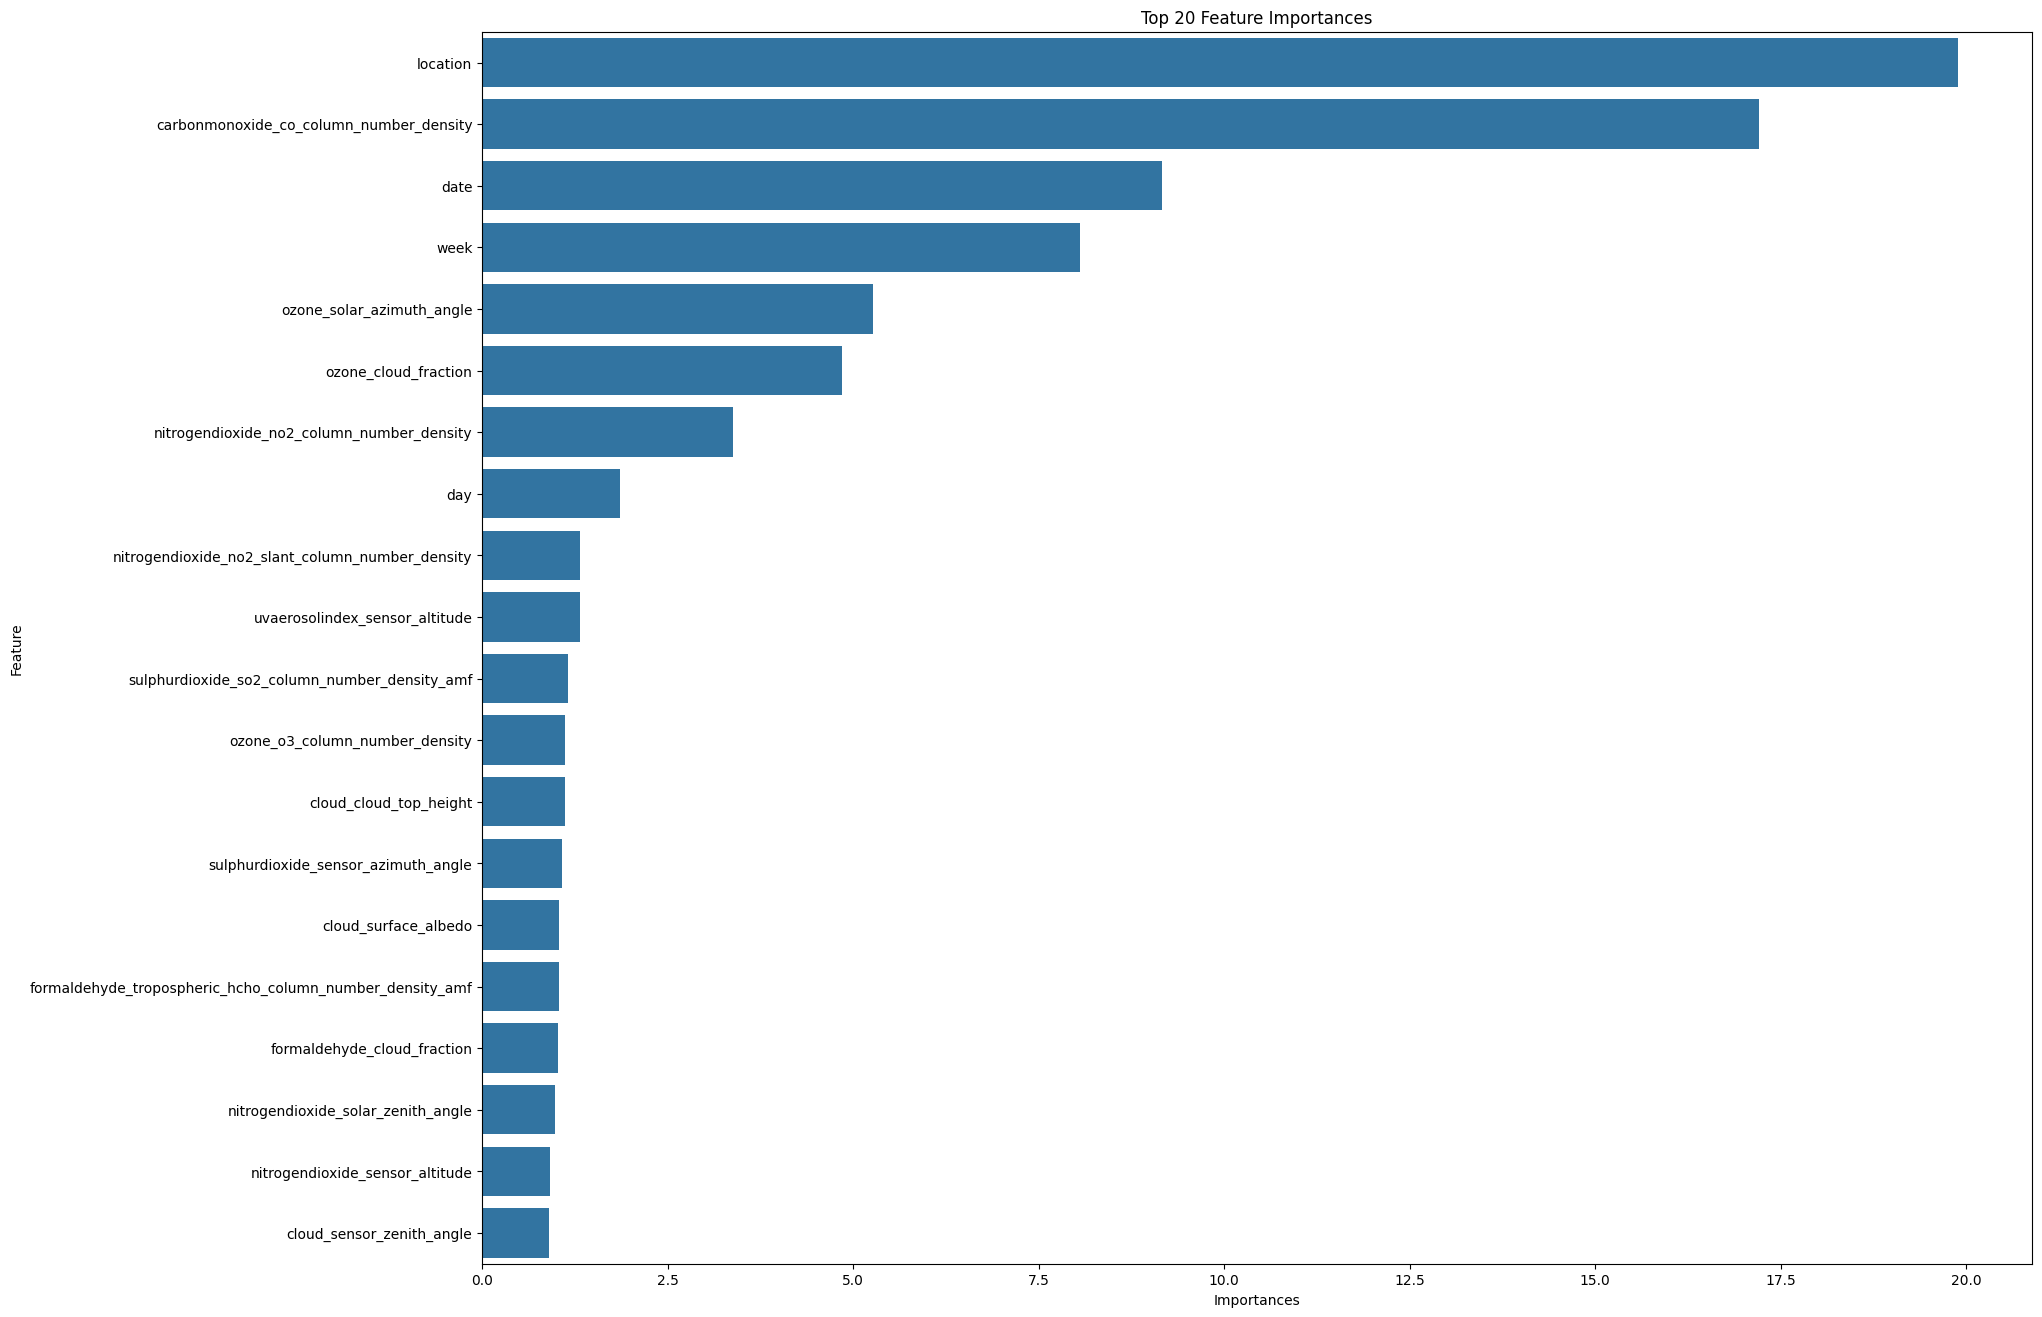

In [144]:
# Plot feature importance from final CatBoost model
plt.figure(figsize=(20, 16))
feature_importances_df = pd.DataFrame(best_models['cat'].feature_importances_, columns=['Importances'])
feature_importances_df['Feature'] = ensemble.reduced_features
sns.barplot(x='Importances', y='Feature', data=feature_importances_df.sort_values(by=['Importances'], ascending=False).head(20))
plt.title('Top 20 Feature Importances')
plt.show()

## Prepare test submission

In [145]:
def prepare_submission(test, best_test_pred, save_path='output/submission.csv'):
    """Prepare submission file."""
    test[Config.target_col] = best_test_pred
    submission = test[[Config.id_col, Config.target_col]]
    submission.to_csv(save_path, index=False)
    submission.head()
    
prepare_submission(test, final_test_preds)